In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import soundfile
import os, glob, pickle
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Preparing the Dataset
features = pd.read_csv("/content/features11.csv") #Path of your the csv file
X = features.iloc[:,:-1].values
Y = features.iloc[:,-1].values

In [ ]:
#Encoding the dependent variable
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10534, 182), (10534, 7), (3512, 182), (3512, 7))

In [ ]:
# Scaling the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# Reshape input features to fit LSTM format (replace with your own code if necessary)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Training the model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=6, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 182, 128)          66560     
                                                                 
 dropout_2 (Dropout)         (None, 182, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 206,790
Trainable params: 206,790
Non-tr

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
199/199 [==============================] - 11s 33ms/step - loss: 0.4542 - accuracy: 0.2199 - val_loss: 0.4331 - val_accuracy: 0.2409 - lr: 0.0010
Epoch 2/100
199/199 [==============================] - 6s 29ms/step - loss: 0.4273 - accuracy: 0.2702 - val_loss: 0.4229 - val_accuracy: 0.2789 - lr: 0.0010
Epoch 3/100
199/199 [==============================] - 5s 26ms/step - loss: 0.4228 - accuracy: 0.2842 - val_loss: 0.4187 - val_accuracy: 0.2914 - lr: 0.0010
Epoch 4/100
199/199 [==============================] - 5s 26ms/step - loss: 0.4195 - accuracy: 0.2925 - val_loss: 0.4134 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 5/100
199/199 [==============================] - 5s 26ms/step - loss: 0.4135 - accuracy: 0.3089 - val_loss: 0.4140 - val_accuracy: 0.2953 - lr: 0.0010
Epoch 6/100
199/199 [==============================] - 5s 26ms/step - loss: 0.4112 - accuracy: 0.3152 - val_loss: 0.4052 - val_accuracy: 0.3217 - lr: 0.0010
Epoch 7/100
199/199 [==============================] - 5s

266/266 [==============================] - 2s 9ms/step - loss: 0.2990 - accuracy: 0.5815
Accuracy of our model on test data :  58.145833015441895 %


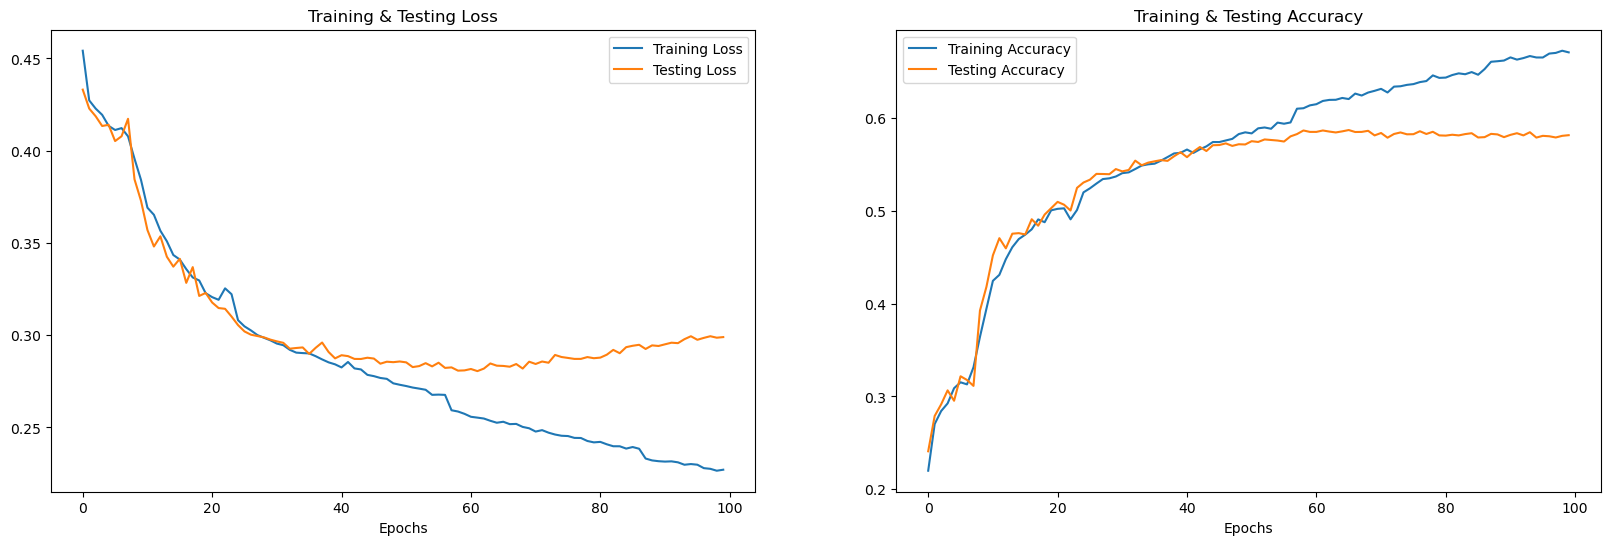

In [ ]:
  print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"
with open(Pkl_Filename, 'wb') as file:
    pickle.dump(model, file)